<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# Загрузим необходимые библиотеки
!pip install scikit-learn==1.1.3 -q
!pip -q install phik
!pip install category_encoders

In [2]:
# Импортируем необходимые нам библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import time
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose


# снимим ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [3]:
# Загрузим данные /datasets/taxi.csv. 
# Ознакомимся с содержимым.
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные успешно загружены. Содержат 26496 строк с датой и временем, интервалами по 10 минут и количеством заказов за этот период. Пропусков нет.

## Подготовка

In [4]:
# Осуществим ресемплирование кратно одному часу
data = data.resample('1H').sum()

In [5]:
# Выделим из даты год, месяц, день, час и день недели
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

In [6]:
print(data.head(5))
print(data.tail(5))

                     num_orders  year  month  day  hour  dayofweek
datetime                                                          
2018-03-01 00:00:00         124  2018      3    1     0          3
2018-03-01 01:00:00          85  2018      3    1     1          3
2018-03-01 02:00:00          71  2018      3    1     2          3
2018-03-01 03:00:00          66  2018      3    1     3          3
2018-03-01 04:00:00          43  2018      3    1     4          3
                     num_orders  year  month  day  hour  dayofweek
datetime                                                          
2018-08-31 19:00:00         136  2018      8   31    19          4
2018-08-31 20:00:00         154  2018      8   31    20          4
2018-08-31 21:00:00         159  2018      8   31    21          4
2018-08-31 22:00:00         223  2018      8   31    22          4
2018-08-31 23:00:00         205  2018      8   31    23          4


Данные охватывает период с 2018-03-01 по 2018-08-31, т.е полгода с марта по конец августа 2018 года.
2018-03-01 был четверг, следовательно понедельник у нас обозначен как 0, воскресенье - 6.

## Анализ

Проанализируем почасовое количество заказов в разрезе по дням недели, месяцам и числам месяца.

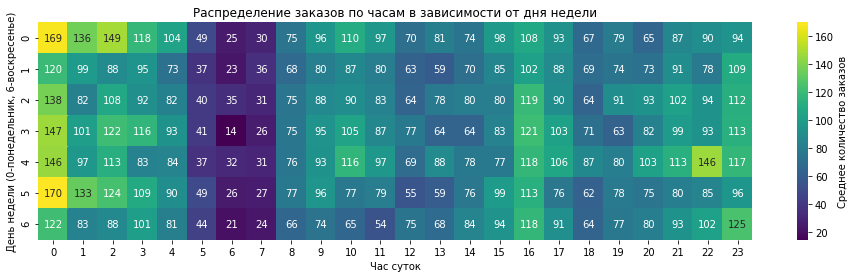

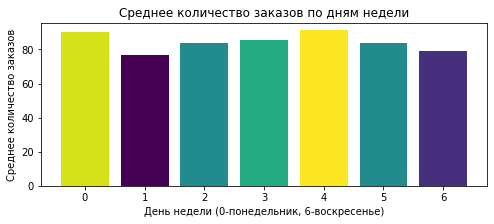

In [7]:
# График распределения по дням недели
plt.figure(figsize=(16, 4))
week_group = data.groupby(['dayofweek', 'hour'])['num_orders'].mean().unstack()
sns.heatmap(week_group, 
            cmap='viridis', 
            annot=True, 
            fmt='.0f', 
            cbar_kws={'label': 'Среднее количество заказов'})

plt.title('Распределение заказов по часам в зависимости от дня недели')
plt.xlabel('Час суток')
plt.ylabel('День недели (0-понедельник, 6-воскресенье)')
plt.xticks(rotation=0)
plt.show()

# Гистограмма по дням недели
plt.figure(figsize=(8, 3))
week_avg = data.groupby('dayofweek')['num_orders'].mean().reset_index()
norm = plt.Normalize(vmin=week_avg['num_orders'].min(), 
                    vmax=week_avg['num_orders'].max())
colors = plt.cm.viridis(norm(week_avg['num_orders']))
plt.bar(week_avg['dayofweek'], 
        week_avg['num_orders'], 
        color=colors)
plt.title('Среднее количество заказов по дням недели')
plt.xlabel('День недели (0-понедельник, 6-воскресенье)')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=0)
plt.show()

Минимальное количество заказов наблюдается в период с 5 до 8 часов утра. Пик заказов такси наблюдается в период с 23 часов вечера до 3 часов ночи. Если явные различия в распределении по дням недели, с относительно тихим периодом вечера субботы и всплеском заказов в ночь на понедельник. По среднему количеству заказов в лидерах понедельник и пятница.

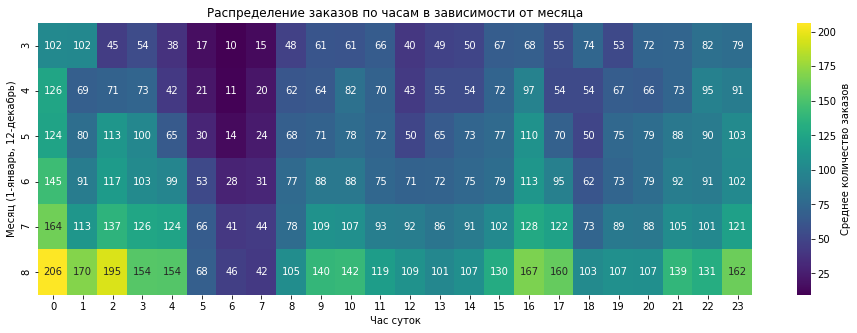

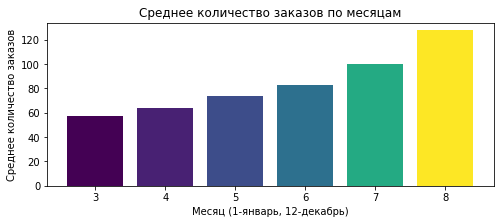

In [8]:
# График распределения по месяцам
plt.figure(figsize=(16, 5))
month_group = data.groupby(['month', 'hour'])['num_orders'].mean().unstack()
sns.heatmap(month_group, 
            cmap='viridis', 
            annot=True, 
            fmt='.0f', 
            cbar_kws={'label': 'Среднее количество заказов'})
plt.title('Распределение заказов по часам в зависимости от месяца')
plt.xlabel('Час суток')
plt.ylabel('Месяц (1-январь, 12-декабрь)')
plt.xticks(rotation=0)
plt.show()

# Гистограмма по месяцам
plt.figure(figsize=(8, 3))
month_avg = data.groupby('month')['num_orders'].mean().reset_index()
norm = plt.Normalize(vmin=month_avg['num_orders'].min(), 
                    vmax=month_avg['num_orders'].max())
colors = plt.cm.viridis(norm(month_avg['num_orders']))
plt.bar(month_avg['month'], 
        month_avg['num_orders'], 
        color=colors)
plt.title('Среднее количество заказов по месяцам')
plt.xlabel('Месяц (1-январь, 12-декабрь)')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=0)
plt.show()

Наблюдается рост заказов такси с наступлением лета, максимальный уровень достигается в августе. Вероятно это связано с периодами отпусков у активного населения. Причем рост наблюдается во всех интервалах времени суток. Август - месяц максимальной активности клиентов из того периода, что нам предоставлен для анализа.

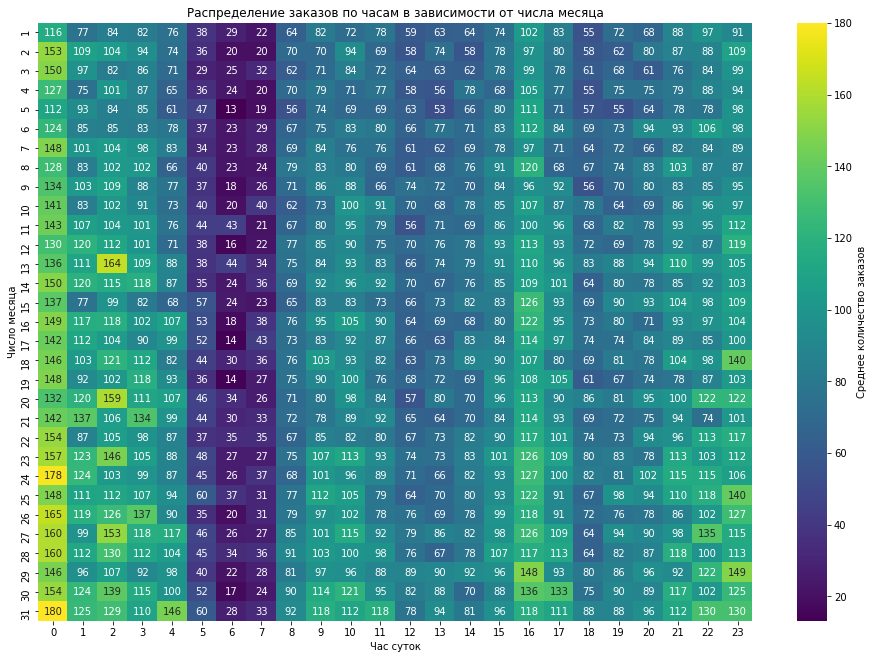

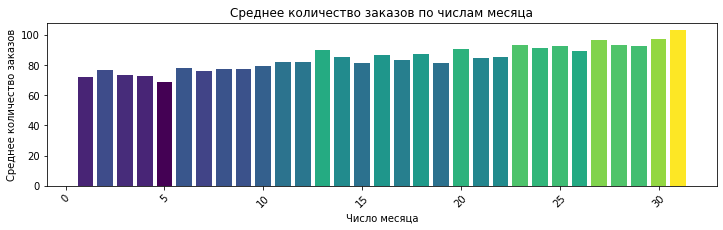

In [9]:
# График распределения по числам месяца
plt.figure(figsize=(16, 11))
day_group = data.groupby(['day', 'hour'])['num_orders'].mean().unstack()

sns.heatmap(day_group, 
            cmap='viridis', 
            annot=True, 
            fmt='.0f', 
            cbar_kws={'label': 'Среднее количество заказов'})

plt.title('Распределение заказов по часам в зависимости от числа месяца')
plt.xlabel('Час суток')
plt.ylabel('Число месяца')
plt.xticks(rotation=0)
plt.show()

# Гистограмма по числам месяца
plt.figure(figsize=(12, 3))
day_avg = data.groupby('day')['num_orders'].mean().reset_index()
norm = plt.Normalize(vmin=day_avg['num_orders'].min(), 
                    vmax=day_avg['num_orders'].max())
colors = plt.cm.viridis(norm(day_avg['num_orders']))
plt.bar(day_avg['day'], 
        day_avg['num_orders'], 
        color=colors)
plt.title('Среднее количество заказов по числам месяца')
plt.xlabel('Число месяца')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=45)
plt.show()

Наблюдается увеличение среднего количества заказов такси ближе к концу календарного месяца. Причем, рост показателя предположительно формируют в основном вечерне-ночные поездки. И период 16-17 часов 29 и 30 числа месяца.

In [10]:
# Удалим колонку с годом, т.к. этот параметр у нас не меняется
data = data.drop(columns='year')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   month       4416 non-null   int64
 2   day         4416 non-null   int64
 3   hour        4416 non-null   int64
 4   dayofweek   4416 non-null   int64
dtypes: int64(5)
memory usage: 207.0 KB


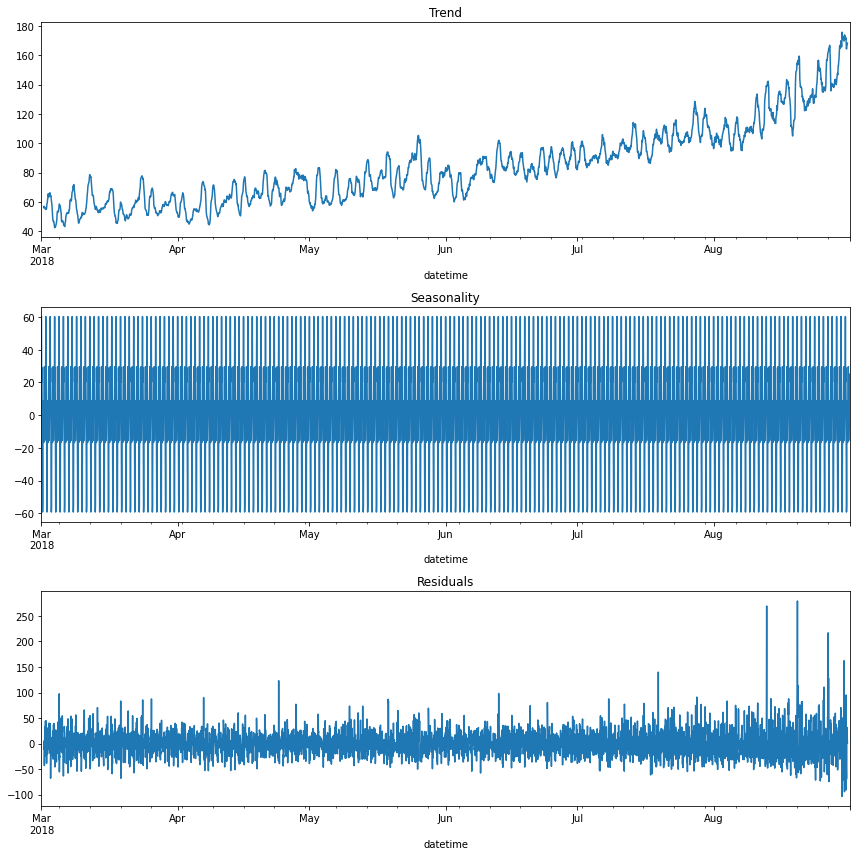

In [11]:
# Разложим ряд на состовляющие: тренд, сезонность и шум
decomposed = seasonal_decompose(data['num_orders']) 

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())  
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())  
plt.title('Residuals')
plt.tight_layout()

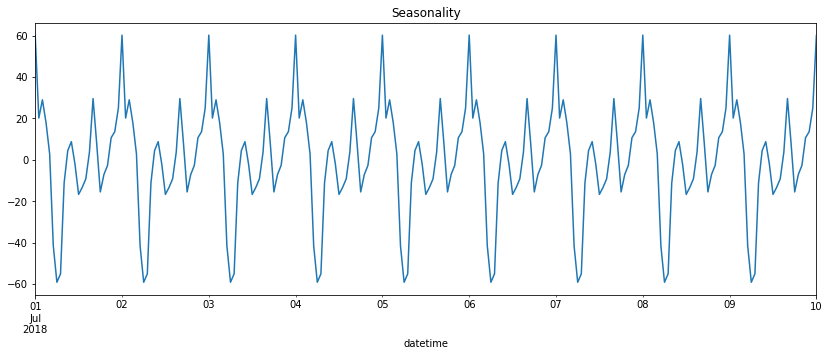

In [12]:
# Посмотрим детальнее на график сезонности
plt.figure(figsize=(14, 5))
decomposed.seasonal.plot(ax=plt.gca())  
plt.title('Seasonality')
plt.xlim(('2018-07-01', '2018-07-10'))
plt.show()

Тренд отражает рост заказов с наступлением лета и увеличением роста со второй половины августа. Сезонность у нас суточная. Амплитуда разброса остатков увеличивается со второй половины августа.

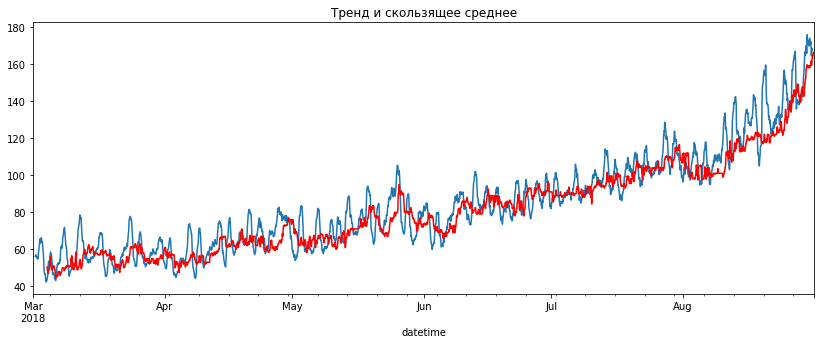

In [13]:
# Для учета тренда добавим в данные скользящее среднее (медиана) с произвольным окном усреднения 
# и выведем на график для сравнения

plt.figure(figsize=(14, 5))
decomposed.trend.plot(ax=plt.gca(), label='Тренд')
data['trend'] = data['num_orders'].rolling(80).median()
data['trend'].plot(ax=plt.gca(), label='Скользящее среднее (100)', color='red')

plt.title('Тренд и скользящее среднее')
plt.show()


Усредненные данные (медиана по последним 80 часам) органично описывают тренд роста числа заказов. Однако, попробуем подобрать окно усреднения с минимальным RMSE от факта. При подборе оптимального окна усреднения ограничим датасет интервалом тренировочной выборки для исключения возможной утечки информации.

Оптимальное окно: 26 с RMSE: 34.2684


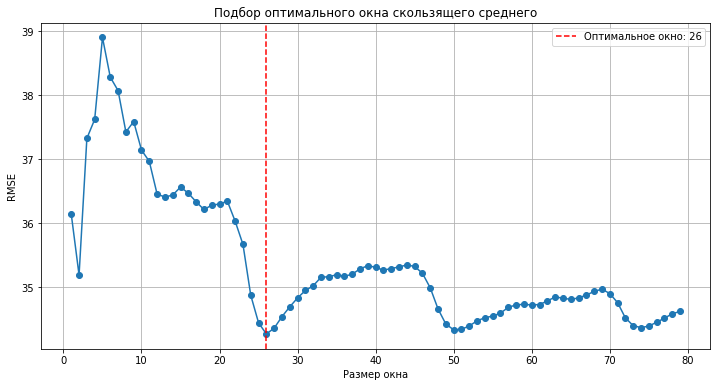

In [14]:
# Инициализируем переменные для поиска оптимального окна
best_rmse = float('inf')
best_window = None
results = []

# Уберем из датасета интервал тестовой выборки
cut_size = int(len(data) * 0.1)
limited_data = data[:-cut_size]


# Определяем диапазон размеров окна для тестирования
window_sizes = range(1, 80)  

# Основной цикл подбора оптимального окна
for window in window_sizes:
    rolling_median = limited_data['num_orders'].shift().rolling(window=window).median()
    valid_data = pd.concat([limited_data['num_orders'], rolling_median], axis=1).dropna()
    
    # Рассчитываем RMSE
    rmse = np.sqrt(mean_squared_error(
        valid_data.iloc[:, 0],  # реальные значения
        valid_data.iloc[:, 1]   # предсказанные значения
    ))
    
    results.append({'window': window, 'rmse': rmse})
    
    # Обновляем лучшее значение
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window

results_df = pd.DataFrame(results)

# Выводим результаты
print(f"Оптимальное окно: {best_window} с RMSE: {best_rmse:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(results_df['window'], results_df['rmse'], marker='o')
plt.axvline(x=best_window, color='red', linestyle='--', label=f'Оптимальное окно: {best_window}')
plt.title('Подбор оптимального окна скользящего среднего')
plt.xlabel('Размер окна')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


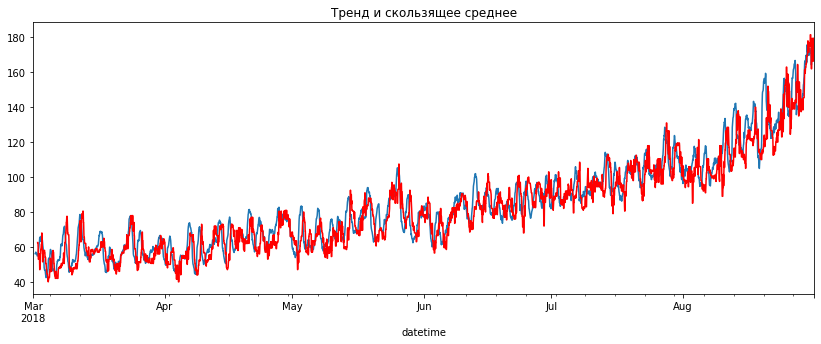

In [15]:
# Пересчитаем предсказание по тренду с оптимальным окном и выведем на график для сравнения
plt.figure(figsize=(14, 5))
decomposed.trend.plot(ax=plt.gca(), label='Тренд')
data['trend'] = data['num_orders'].rolling(26).median()
data['trend'].plot(ax=plt.gca(), label='Скользящее среднее (100)', color='red')
plt.title('Тренд и скользящее среднее')
plt.show()


Усреднение по последним 26 часам хорошо отражает имеющийся тренд изменения количества заказов.

In [16]:
# Удалим пропуски возникшие пропуски в данных
data.dropna(inplace=True)

Выведем матрицу корреляции

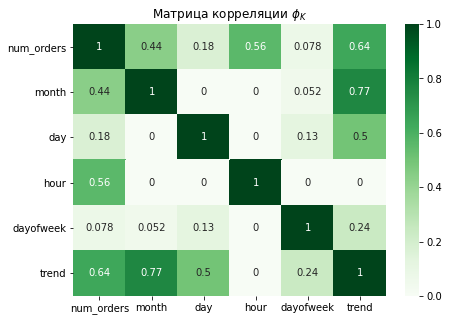

In [17]:
# Обозначим количественные признаки для матрицы
interval_cols = ['num_orders', 'month', 'day', 'hour', 'dayofweek', 'trend']

# Выведем матрицу корреляции
target_matrix = data.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(7, 5))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [18]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['num_orders'].sort_values(ascending=False)

num_orders    1.000000
trend         0.638857
hour          0.561126
month         0.439241
day           0.175342
dayofweek     0.077551
Name: num_orders, dtype: float64

Согласно матрицы, с целевым признаком наилучшая корреляционная связь у признака тренд и час заказа, затем у месяца, дня месяца и только потом идет день недели. Не ожиданно, но день недели меньше всего коррелируется с динамикой спроса на такси.

## Обучение

In [19]:
# Разделим датасет на тренировочную и тестовую выборки согласно задания, выведем получившиеся интервалы
train, test = train_test_split(data, shuffle=False, test_size=0.1) 

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 01:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


В тестовую выборку попали данные с 13 по 31 августа. Непростой период, с более высоким количеством заказов, как было отмечено ранее.

In [20]:
# Выделим целевой признак
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

In [21]:
# Создадим функцию для вывода результатов модели
def evaluate_model(model, params, X_train, y_train, n_splits=5):
    # Создаем объект TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Grid Search для поиска лучших параметров
    grid = GridSearchCV(
        model, 
        params, 
        scoring='neg_mean_squared_error', 
        cv=tscv,  # используем TimeSeriesSplit
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    
    # Получаем метрики из результатов GridSearch
    mean_fit_time = np.mean(grid.cv_results_['mean_fit_time'])
    mean_score_time = np.mean(grid.cv_results_['mean_score_time'])
    
    # Преобразуем оценку из отрицательной MSE в RMSE
    mean_rmse = (-grid.best_score_)**0.5
    
    return {
        'best_params': grid.best_params_,
        'rmse': mean_rmse,
        'mean_fit_time': mean_fit_time,
        'mean_score_time': mean_score_time,
        'best_estimator': grid.best_estimator_
    }


Обучим четыре модели и выведем лучшие гиперпараметры, метрику RMSE и затраченной время на обучение и предсказание для каждой модели.

In [22]:
# 1. Линейная регрессия
print("Линейная регрессия")
linear_pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    LinearRegression()
)

linear_params = {}

linear_results = evaluate_model(linear_pipeline, linear_params, X_train, y_train)
print(f"Лучшие параметры: {linear_results['best_params']}")
print(f"RMSE: {linear_results['rmse']:.4f}")
print(f"Время обучения: {linear_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {linear_results['mean_score_time']:.2f} секунд\n")


# 2. Decision Tree
print("Decision Tree")
tree_params = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_results = evaluate_model(DecisionTreeRegressor(), tree_params, X_train, y_train)
print(f"Лучшие параметры: {tree_results['best_params']}")
print(f"RMSE: {tree_results['rmse']:.4f}")
print(f"Время обучения: {tree_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {tree_results['mean_score_time']:.2f} секунд\n")


# 3. CatBoost
print("CatBoost")
catboost_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

catboost_results = evaluate_model(CatBoostRegressor(verbose=0), catboost_params, X_train, y_train)
print(f"Лучшие параметры: {catboost_results['best_params']}")
print(f"RMSE: {catboost_results['rmse']:.4f}")
print(f"Время обучения: {catboost_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {catboost_results['mean_score_time']:.2f} секунд\n")


# 4. LGBM
print("LGBM")
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1]
}

lgbm_results = evaluate_model(LGBMRegressor(), lgbm_params, X_train, y_train)
print(f"Лучшие параметры: {lgbm_results['best_params']}")
print(f"RMSE: {lgbm_results['rmse']:.4f}")
print(f"Время обучения: {lgbm_results['mean_fit_time']:.2f} секунд")
print(f"Время предсказания: {lgbm_results['mean_score_time']:.2f} секунд\n")

Линейная регрессия
Лучшие параметры: {}
RMSE: 34.2126
Время обучения: 0.01 секунд
Время предсказания: 0.00 секунд

Decision Tree
Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE: 26.6093
Время обучения: 0.00 секунд
Время предсказания: 0.00 секунд

CatBoost
Лучшие параметры: {'iterations': 200, 'learning_rate': 0.1}
RMSE: 24.2019
Время обучения: 0.83 секунд
Время предсказания: 0.00 секунд

LGBM
Лучшие параметры: {'learning_rate': 0.05, 'n_estimators': 100}
RMSE: 24.6059
Время обучения: 1.10 секунд
Время предсказания: 0.04 секунд



Обучены четыре модели, получены для каждой модели лучшие гиперпараметры по метрике RMSE.

In [23]:
# Сохранение результатов в словарь
results = {
    'LinearRegression': linear_results,
    'DecisionTree': tree_results,
    'CatBoost': catboost_results,
    'LGBM': lgbm_results
}

# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'RMSE, евро': [results[model]['rmse'] for model in results],
    'Время обучения, сек': [results[model]['mean_fit_time'] for model in results],
    'Время предсказания, сек': [results[model]['mean_score_time'] for model in results],
    'Best Params': [results[model]['best_params'] for model in results]
}, index=None)

print("Результаты моделей:")

display(results_df.sort_values(by='RMSE, евро', ascending=True).reset_index(drop=True).style.format({
    'RMSE, евро': '{:.2f}',
    'Время обучения, сек': '{:.2f}'
}))

# Выведем лучшую модель по RMSE
best_rmse_model = results_df.loc[results_df['RMSE, евро'].idxmin()]

# Выводим информацию о лучшей модели по RMSE
print("\nЛучшая модель по RMSE:")
print(f"Модель: {best_rmse_model['Модель']}")
print(f"RMSE: {best_rmse_model['RMSE, евро']:.2f}")
print(f"Время обучения: {best_rmse_model['Время обучения, сек']:.2f} секунд")
print(f"Время предсказания: {best_rmse_model['Время предсказания, сек']:.2f} секунд")
print(f"Параметры модели: {best_rmse_model['Best Params']}")

Результаты моделей:


,Модель,"RMSE, евро","Время обучения, сек","Время предсказания, сек",Best Params
0,CatBoost,24.20,0.83,0.001835,"{'iterations': 200, 'learning_rate': 0.1}"
1,LGBM,24.61,1.10,0.036734,"{'learning_rate': 0.05, 'n_estimators': 100}"
2,DecisionTree,26.61,0.00,0.001467,"{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}"
3,LinearRegression,34.21,0.01,0.001871,{}



Лучшая модель по RMSE:
Модель: CatBoost
RMSE: 24.20
Время обучения: 0.83 секунд
Время предсказания: 0.00 секунд
Параметры модели: {'iterations': 200, 'learning_rate': 0.1}


## Тестирование

Протестируем лучшую модель на тестовых данных.

In [24]:
# Загружаем лучшую модель
best_estimator = catboost_results['best_estimator']

# Делаем предсказания на тестовых данных
y_test_pred = best_estimator.predict(X_test)

# Оцениваем результаты
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE на тестовых данных: {test_rmse:.4f}")

RMSE на тестовых данных: 37.1588


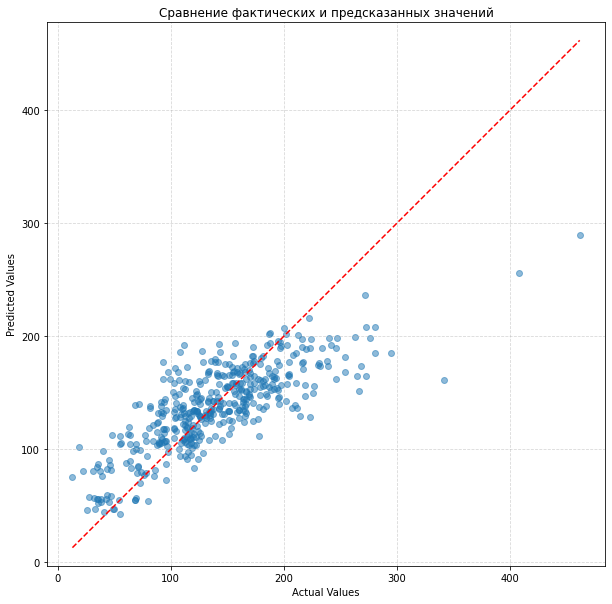

In [25]:
# Построим график сравнения фактических и предсказанных значений
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()

Модель слегка занижает предсказанное количество заказов такси в интервале высоких значений. Это было ожидаемо, т.к. в тестовую выборку у нас входит вторая половина августа. Тем не менее, пороговое значение метрики RMSE < 48 достигнуто и составило 37.2 заказа.

## Вывод

Для исследования нам были предоставлены данные по заказам такси за период с марта по август включительно 2018 года. Данные включали количество заказов за каждые 10 минут. 
<br><br>При подготовке данные были ресепмлированы с интервалом один час, из даты и времени выделены признаки час заказа, месяц заказа, день месяца и день недели. Затем был произведен анализ полученных признаков на наличие корреляционной связи с количеством заказов. 
<br>
Временной ряд был разложен на составляющие отражающие тренд, суточную сезонность и разброс остатков. По результатам анализа в данные был добавлен показатель медианного значения количества заказов за последние 26 часов.
<br>
Затем, датасет был подготовлен к обучению, с выделением тестовой выборки охватывающей период с 13 по 31 августа (10% от объема данных).
<br><br>
В процессе работы были обучены четыре модели машинного обучения: Линейная регрессия, DecissionTree регрессия, CatBoostRegressor и Регрессия LGBM. При обучении моделей осуществялся перебор нескольких гиперпараметров для каждой модели. По метрике RMSE отобраны лучшие гиперпараметры для каждой модели.
По результатам отбора лучшей моделью стала:
<br>Модель: CatBoost
<br>RMSE: 24.20
<br>Время обучения: 0.83 секунд
<br>Время предсказания: 0.00 секунд
<br>Параметры модели: {'iterations': 200, 'learning_rate': 0.1}
<br>
<br>
Данная модель была протестирована на тестовых данных, метрика RMSE составила 37.2 заказа. Данный результат укладывается в допуск по критериям задачи (не более 48 заказов). Снижение уровня метрики относительно тренировочных данных объясняется несбаласированностью тестовой выборки относительно тренировочной, возникшей из условий задачи и периода предоставленных данных для исследования.